In [78]:
import json
import pandas as pd
from datetime import datetime
from pathlib import Path

def load_data(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

def extract_tweet_features(data):
    all_tweets = []

    for influencer in data:
        user_id = influencer["user_id"]
        username = influencer["username"]
        tweets = influencer.get("tweets", {}).get("result", {}).get("timeline", {}).get("instructions", [])

        for instr in tweets:
            if instr.get("type") == "TimelineAddEntries":
                for entry in instr.get("entries", []):
                    try:
                        tweet = entry["content"]["itemContent"]["tweet_results"]["result"]
                        legacy = tweet["legacy"]
                        created_at = legacy["created_at"]
                        dt = datetime.strptime(created_at, "%a %b %d %H:%M:%S %z %Y")

                        # Engagement features
                        tweet_features = {
                            "user_id": user_id,
                            "username": username,
                            "tweet_id": tweet["rest_id"],
                            "created_at": dt.isoformat(),
                            "hour": dt.hour,
                            "day_of_week": dt.strftime("%A"),
                            "is_weekend": dt.weekday() >= 5,
                            "source": tweet.get("source", ""),
                            "text_length": len(legacy.get("full_text", "")),
                            "num_hashtags": len(legacy["entities"].get("hashtags", [])),
                            "num_mentions": len(legacy["entities"].get("user_mentions", [])),
                            "num_urls": len(legacy["entities"].get("urls", [])),
                            "has_media": "media" in legacy["entities"],
                            "likes": legacy.get("favorite_count", 0),
                            "retweets": legacy.get("retweet_count", 0),
                            "replies": legacy.get("reply_count", 0),
                            "quotes": legacy.get("quote_count", 0),
                            "views": int(tweet.get("views", {}).get("count", 0)),
                            "followers": tweet["core"]["user_results"]["result"]["legacy"]["followers_count"],
                        }

                        tweet_features["engagement_rate"] = (
                            tweet_features["likes"] + tweet_features["retweets"] + tweet_features["replies"]
                        ) / max(tweet_features["followers"], 1)

                        all_tweets.append(tweet_features)
                    except Exception as e:
                        print(f"Skipping tweet due to error: {e}")
                        continue

    return pd.DataFrame(all_tweets)






In [79]:
from pathlib import Path
import pandas as pd
import json
from datetime import datetime

input_path = "data/raw/tweets_data.json"
output_path = "data/processed/tweets_engagement_dataset.csv"

# Load and extract
data = load_data(input_path)
df = extract_tweet_features(data)

# Sort per influencer by timestamp
df.sort_values(by=["user_id", "created_at"], inplace=True)

# Save to CSV
df.to_csv(output_path, index=False)
print(f"Extracted dataset saved to {output_path}")

# Parse datetime
df["created_at"] = pd.to_datetime(df["created_at"])

# Define latest and 6 months ago
latest = df["created_at"].max()
six_months_ago = latest - pd.DateOffset(months=6)

# 🛠 Only localize if not already tz-aware
if six_months_ago.tzinfo is None and latest.tzinfo is not None:
    six_months_ago = six_months_ago.tz_localize(latest.tzinfo)

# Filter
df_recent = df[df["created_at"] >= six_months_ago]

# Output
print("Latest tweet:", latest)
print("6 months ago:", six_months_ago)
print(f"Filtered tweets count: {len(df_recent)}")
print(f"Earliest filtered tweet: {df_recent['created_at'].min()}")
print(f"Latest filtered tweet: {df_recent['created_at'].max()}")


Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tweet due to error: 'itemContent'
Skipping tw

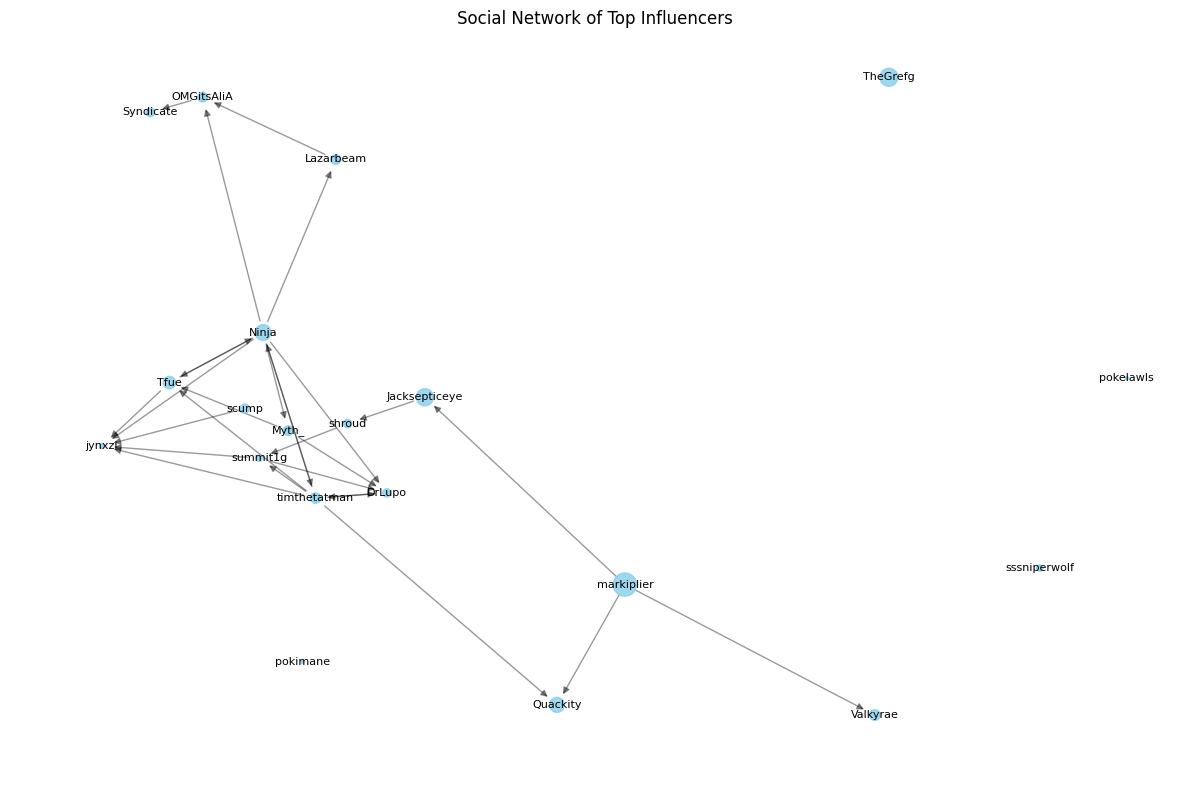

Network Statistics:
Number of nodes: 20
Number of edges: 28
Network density: 0.0737

Influencer Summary:
                name    screen_name  followers_count
14              Mark     markiplier         13865741
12          Grefg =)       TheGrefg          8387320
9      Jacksepticeye  Jacksepticeye          7627231
0              Ninja          Ninja          6528161
11          Quackity       Quackity          5780664
8               Tfue           Tfue          4066596
10               RAE       Valkyrae          2944525
4      timthetatman👑   timthetatman          2817583
18             LAZAR      Lazarbeam          2540244
2               Myth          Myth_          2404818
16             Ali-A     OMGitsAliA          2383888
17       OpTic Scump          scump          2240844
5                Tom      Syndicate          1958706
1   Michael Grzesiek         shroud          1844237
3             DrLupo         DrLupo          1815186
15               Lia   sssniperwolf          10

In [80]:
# Task 2: Social Network Construction (Real Data)
import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd

# Load the collected data
with open('data/raw/influencer_profiles.json', 'r') as f:
    influencer_profiles = json.load(f)

with open('data/raw/following_data.json', 'r') as f:
    following_data = json.load(f)

# Create a directed graph
G = nx.DiGraph()

# Store influencer nodes with their metadata
influencer_nodes = []
user_id_map = {}  # screen_name.lower() → user_id
screen_name_map = {}  # user_id → screen_name.lower()

# Add influencer nodes to graph
for profile in influencer_profiles:
    try:
        user_data = profile['result']['data']['user']['result']
        user_id = user_data['rest_id']
        screen_name = user_data['legacy']['screen_name']
        name = user_data['legacy']['name']
        followers_count = user_data['legacy']['followers_count']
        friends_count = user_data['legacy']['friends_count']
        statuses_count = user_data['legacy']['statuses_count']

        G.add_node(user_id,
                   screen_name=screen_name,
                   name=name,
                   followers_count=followers_count,
                   friends_count=friends_count,
                   statuses_count=statuses_count,
                   is_influencer=True)

        influencer_nodes.append({
            'user_id': user_id,
            'screen_name': screen_name,
            'name': name,
            'followers_count': followers_count,
            'friends_count': friends_count,
            'statuses_count': statuses_count
        })

        user_id_map[screen_name.lower()] = user_id
        screen_name_map[user_id] = screen_name.lower()

    except (KeyError, TypeError) as e:
        print(f"Error processing profile: {e}")

# Convert to DataFrame for analysis
influencer_df = pd.DataFrame(influencer_nodes)

# Extract real following relationships to build edges
def extract_following_ids(entries):
    user_ids = set()
    for entry in entries:
        try:
            content = entry['content']['itemContent']
            followed_id = content['user_results']['result']['rest_id']
            user_ids.add(followed_id)
        except (KeyError, TypeError):
            continue
    return user_ids

# Create edges: source → target if source follows target and both are influencers
influencer_ids = set(screen_name_map.keys())

for item in following_data:
    source_id = item['user_id']
    instructions = item.get('following', {}).get('result', {}).get('timeline', {}).get('instructions', [])

    # Find the 'TimelineAddEntries' section with actual data
    for instruction in instructions:
        if instruction.get('type') == 'TimelineAddEntries':
            entries = instruction.get('entries', [])
            followed_ids = extract_following_ids(entries)

            for target_id in followed_ids:
                if target_id in influencer_ids:
                    G.add_edge(source_id, target_id, weight=1)

# Visualize the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes
node_sizes = [G.nodes[n]['followers_count'] / 1_000_000 for n in G.nodes()]
nx.draw_networkx_nodes(G, pos,
                       node_size=[max(5, size * 20) for size in node_sizes],
                       node_color='skyblue',
                       alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4)

# Draw labels
labels = {node: G.nodes[node]['screen_name'] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Social Network of Top Influencers")
plt.axis('off')
plt.tight_layout()
plt.savefig('data/outputs/visualizations/influencer_network.png', dpi=300)
plt.show()
plt.close()

# Save the graph
nx.write_gexf(G, 'data/processed/influencer_network.gexf')

# Display stats
print("Network Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# Display influencer info
print("\nInfluencer Summary:")
print(influencer_df[['name', 'screen_name', 'followers_count']].sort_values(by='followers_count', ascending=False))

print("\nSocial network construction (real data) completed!")


Community detection based on network structure (Louvain) completed.


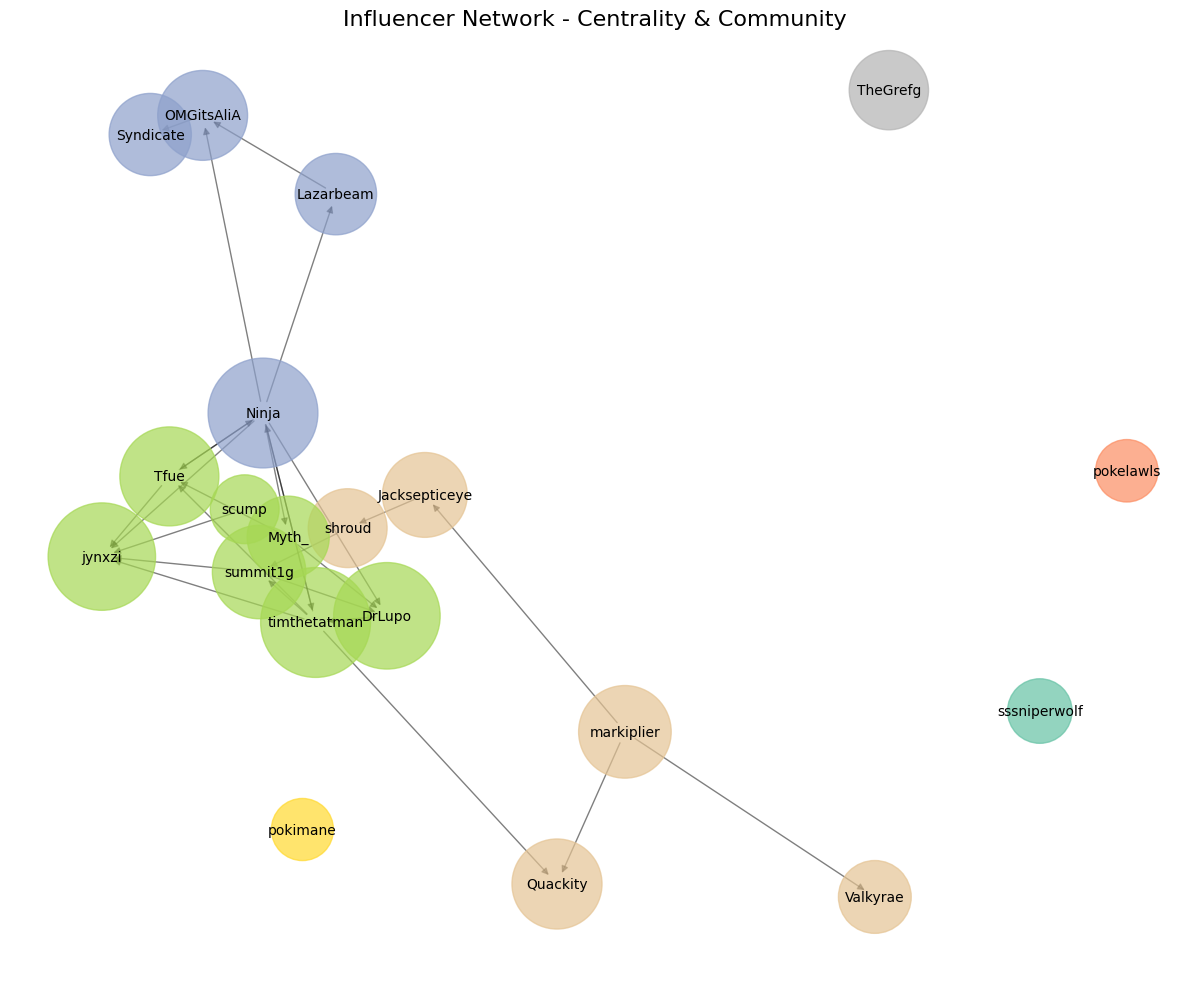

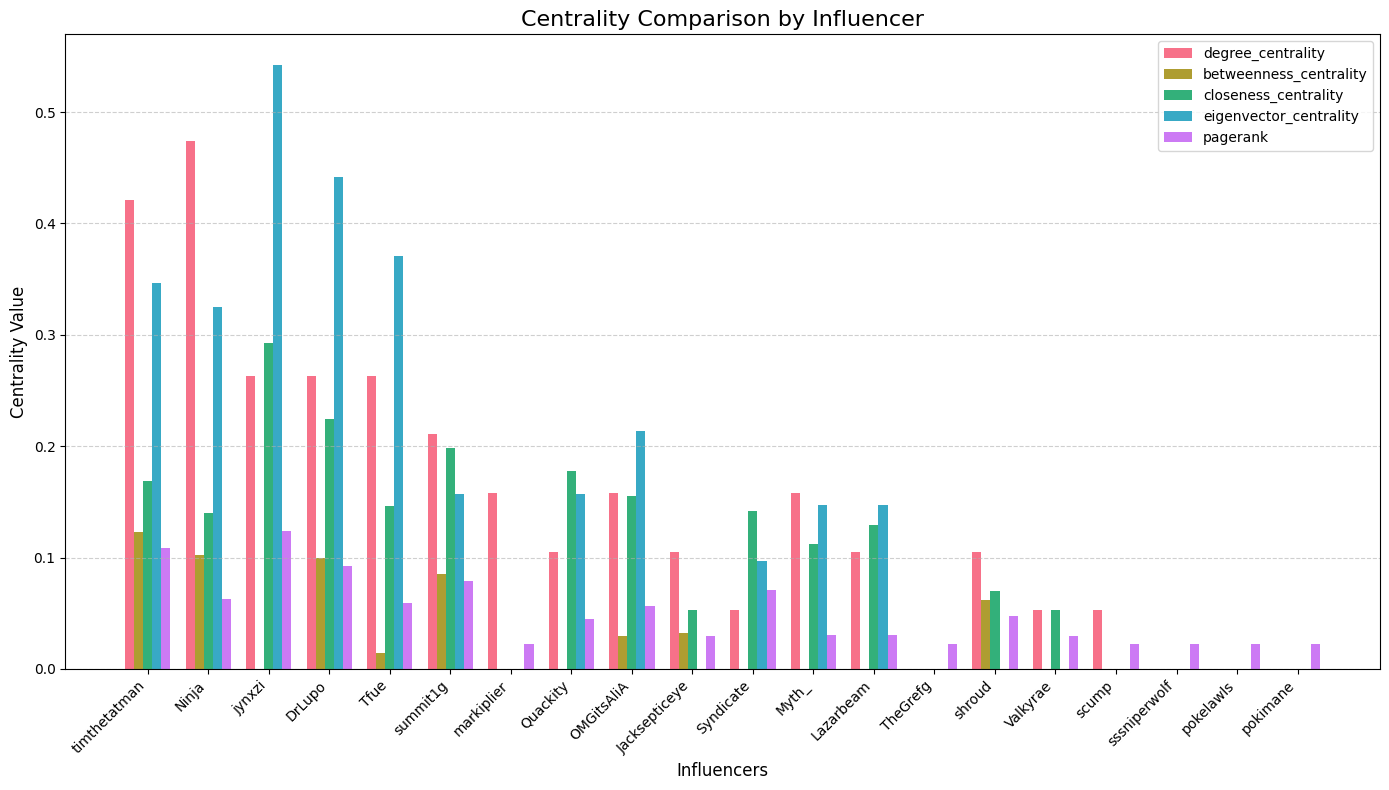

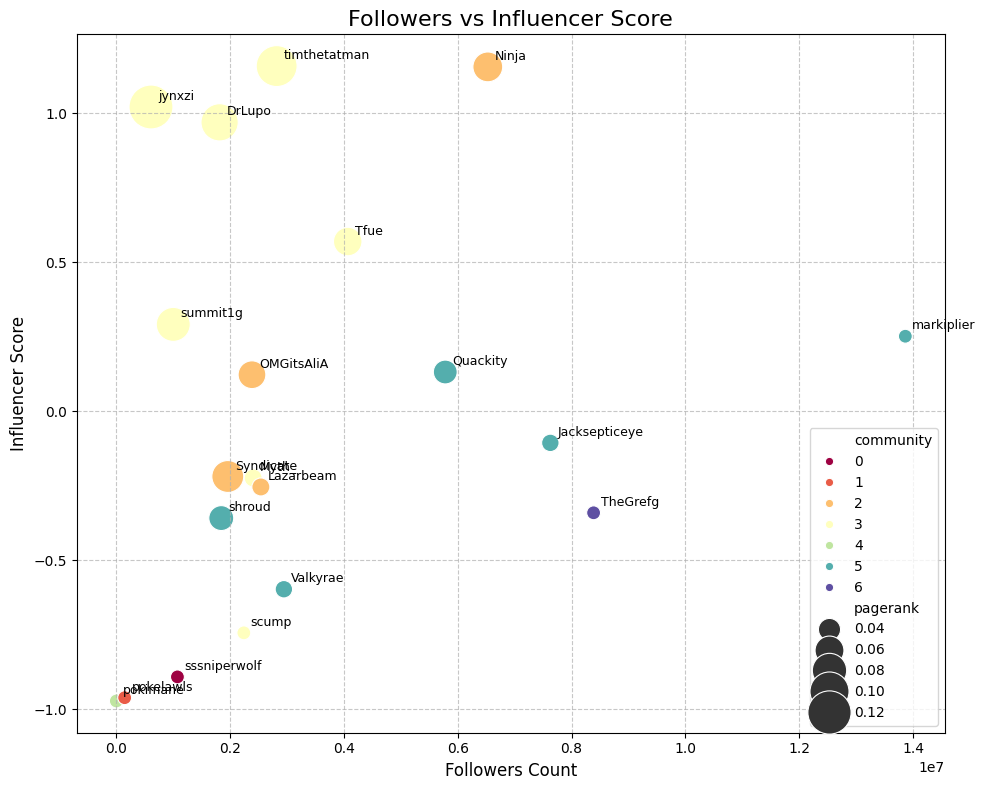

Top 5 Influencers Based on Composite Score:
             name   screen_name  followers_count  influencer_score
4   timthetatman👑  timthetatman        2817583.0          1.157466
0           Ninja         Ninja        6528161.0          1.154808
13         Jynxzi        jynxzi         609082.0          1.020255
3          DrLupo        DrLupo        1815186.0          0.968799
8            Tfue          Tfue        4066596.0          0.569018

Social network analysis completed!

Top influencers in each community based on influencer score:

Community 0:
     screen_name  followers_count  influencer_score
15  sssniperwolf        1073854.0         -0.891081

Community 1:
   screen_name  followers_count  influencer_score
19   pokelawls         146656.0         -0.960856

Community 2:
   screen_name  followers_count  influencer_score
0        Ninja        6528161.0          1.154808
16  OMGitsAliA        2383888.0          0.122382
5    Syndicate        1958706.0         -0.218962

Community

In [81]:
# Task 3: Social Network Analysis
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the influencer network graph
G = nx.read_gexf('data/processed/influencer_network.gexf')

# === 1. CENTRALITY ANALYSIS ===
# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
pagerank = nx.pagerank(G)

# Combine into DataFrame
centrality_df = pd.DataFrame({
    'user_id': list(G.nodes()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    'closeness_centrality': list(closeness_centrality.values()),
    'eigenvector_centrality': list(eigenvector_centrality.values()),
    'pagerank': list(pagerank.values())
})

# Add influencer attributes from the graph
for i, node in enumerate(centrality_df['user_id']):
    centrality_df.loc[i, 'name'] = G.nodes[node]['name']
    centrality_df.loc[i, 'screen_name'] = G.nodes[node]['screen_name']
    centrality_df.loc[i, 'followers_count'] = float(G.nodes[node]['followers_count'])
    centrality_df.loc[i, 'friends_count'] = float(G.nodes[node]['friends_count'])
    centrality_df.loc[i, 'statuses_count'] = float(G.nodes[node]['statuses_count'])

# === 2. INFLUENCER SCORE ===
# Normalize centrality + followers data
scaler = StandardScaler()
features = ['degree_centrality', 'betweenness_centrality', 
            'closeness_centrality', 'eigenvector_centrality', 
            'pagerank', 'followers_count']
scaled_centrality = scaler.fit_transform(centrality_df[features])

# Weighted score
weights = [0.15, 0.10, 0.10, 0.25, 0.15, 0.25]
influencer_scores = np.dot(scaled_centrality, np.array(weights))
centrality_df['influencer_score'] = influencer_scores

# === 3. COMMUNITY DETECTION BASED ON GRAPH STRUCTURE ===
try:
    import community as community_louvain  # Make sure you have 'python-louvain' installed
except ImportError:
    raise ImportError("Please install it via pip: pip install python-louvain")

# Convert to undirected for better community detection
G_undirected = G.to_undirected()

# Run Louvain algorithm on the graph (structure-based)
partition = community_louvain.best_partition(G_undirected, resolution=1.0)

# Map communities back to the DataFrame
centrality_df['community'] = centrality_df['user_id'].map(partition)

# Assign community as node attribute in graph
nx.set_node_attributes(G, partition, 'community')

print("Community detection based on network structure (Louvain) completed.")


# === 4. ANALYSIS OUTPUT ===
# Save centrality metrics and scores
centrality_df.to_csv('data/outputs/centrality/influencer_centrality.csv', index=False)

# === 5. VISUALIZATIONS ===
# Network with influencer score + community
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
node_sizes = [(score + abs(min(influencer_scores)) + 1) * 2000 for score in influencer_scores]
node_colors = [centrality_df.loc[centrality_df['user_id'] == node, 'community'].values[0] for node in G.nodes()]


nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7, cmap=plt.cm.Set2)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={node: centrality_df.loc[centrality_df['user_id'] == node, 'screen_name'].values[0] for node in G.nodes()}, font_size=10)
plt.title("Influencer Network - Centrality & Community", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig('data/outputs/visualizations/influencer_analysis_network.png', dpi=300)
plt.show()
plt.close()

# Centrality bar comparison
plt.figure(figsize=(14, 8))
measure_cols = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank']
colors = sns.color_palette("husl", len(measure_cols))
sorted_df = centrality_df.sort_values('influencer_score', ascending=False)
x = np.arange(len(sorted_df))
width = 0.15

for i, column in enumerate(measure_cols):
    plt.bar(x + i*width, sorted_df[column], width, label=column, color=colors[i])

plt.xlabel('Influencers', fontsize=12)
plt.ylabel('Centrality Value', fontsize=12)
plt.title('Centrality Comparison by Influencer', fontsize=16)
plt.xticks(x + width*2, sorted_df['screen_name'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('data/outputs/visualizations/centrality_comparison.png', dpi=300)
plt.show()
plt.close()

# Followers vs Influencer Score
plt.figure(figsize=(10, 8))
sns.scatterplot(x='followers_count', y='influencer_score',
                hue='community', size='pagerank', sizes=(100, 1000),
                data=centrality_df, palette='Spectral')

for i, row in centrality_df.iterrows():
    plt.annotate(row['screen_name'], (row['followers_count'], row['influencer_score']),
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title("Followers vs Influencer Score", fontsize=16)
plt.xlabel("Followers Count", fontsize=12)
plt.ylabel("Influencer Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('data/outputs/visualizations/followers_vs_score.png', dpi=300)
plt.show()
plt.close()

# === 6. OUTPUT TOP INFLUENCERS AND COMMUNITY STATS ===
print("Top 5 Influencers Based on Composite Score:")
print(centrality_df[['name', 'screen_name', 'followers_count', 'influencer_score']].sort_values(by='influencer_score', ascending=False).head(5))

# print("\nCommunity Group Summary (mean influencer score per group):")
# print(centrality_df.groupby('community')['influencer_score'].mean().reset_index().sort_values(by='influencer_score', ascending=False))

print("\nSocial network analysis completed!")

print("\nTop influencers in each community based on influencer score:")
for comm_id in sorted(centrality_df['community'].unique()):
    print(f"\nCommunity {comm_id}:")
    top_group = centrality_df[centrality_df['community'] == comm_id].sort_values("influencer_score", ascending=False).head(3)
    print(top_group[['screen_name', 'followers_count', 'influencer_score']])
    
num_communities = len(set(partition.values()))
print(f"\nTotal communities detected: {num_communities}")




In [82]:
# Load centrality features
centrality_path = "data/outputs/centrality/influencer_centrality.csv"
df_centrality = pd.read_csv(centrality_path)

# Ensure both user_id columns are the same type before merging
df["user_id"] = df["user_id"].astype(str)
df_centrality["user_id"] = df_centrality["user_id"].astype(str)

# Now perform the merge
df = df.merge(df_centrality, on="user_id", how="left", suffixes=("", "_centrality"))


# Optional: check for any missing merges
missing = df_merged[df_merged["degree_centrality"].isna()]
print(f"Missing centrality data for {len(missing)} tweets.")
print(missing["username"].unique())

# Continue using `df_merged` instead of `df`
df = df_merged

print(df.columns.tolist())


Missing centrality data for 92 tweets.
['Jynxzi' 'Summit1g' 'Pokelawls' 'LazarBeam' 'SSSniperWolf' 'TimTheTatman']
['user_id_x', 'username', 'tweet_id', 'created_at', 'hour', 'day_of_week', 'is_weekend', 'source', 'text_length', 'num_hashtags', 'num_mentions', 'num_urls', 'has_media', 'likes', 'retweets', 'replies', 'quotes', 'views', 'followers', 'engagement_rate', 'user_id_y', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank', 'influencer_score', 'community']


In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Drop non-numeric / non-useful columns
df = df.drop(columns=["tweet_id", "created_at", "username", "user_id_x"])


# Convert booleans
df["has_media"] = df["has_media"].astype(int)
df["is_weekend"] = df["is_weekend"].astype(int)

# One-hot encode day_of_week and source
df = pd.get_dummies(df, columns=["day_of_week", "source"], drop_first=True)

# Rename source columns for readability
import re
new_cols = []
for col in df.columns:
    if col.startswith("source_"):
        match = re.search(r'>(.*?)<', col)
        if match:
            clean_name = "source_" + match.group(1)
            new_cols.append(clean_name)
        else:
            new_cols.append(col)
    else:
        new_cols.append(col)

df.columns = new_cols

print(list(df.columns))


# Split
X = df.drop("engagement_rate", axis=1)
y = df["engagement_rate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize and train model
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
features = X_train.columns


['hour', 'is_weekend', 'text_length', 'num_hashtags', 'num_mentions', 'num_urls', 'has_media', 'likes', 'retweets', 'replies', 'quotes', 'views', 'followers', 'engagement_rate', 'user_id_y', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank', 'influencer_score', 'community', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'source_Twitter for iPhone', 'source_Twitter Web App', 'source_Twitter Media Studio', 'source_TweetDeck Web App']


In [84]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", rmse)


R² Score: 0.2740611470887139
RMSE: 0.0046196091441897905


   username       date  followers_count  engagement_rate  degree_centrality  \
36   DrLupo 2023-01-01        1815186.0         0.178570           0.263158   
37   DrLupo 2023-01-08        1815186.0         0.145517           0.263158   
38   DrLupo 2023-01-15        1815186.0         0.154549           0.263158   
39   DrLupo 2023-01-22        1815186.0         0.103821           0.263158   
40   DrLupo 2023-01-29        1815186.0         0.109319           0.263158   

    betweenness_centrality  closeness_centrality  eigenvector_centrality  \
36                0.099415              0.224561                0.441571   
37                0.099415              0.224561                0.441571   
38                0.099415              0.224561                0.441571   
39                0.099415              0.224561                0.441571   
40                0.099415              0.224561                0.441571   

    pagerank  influencer_score  
36  0.092181          0.916908  
37

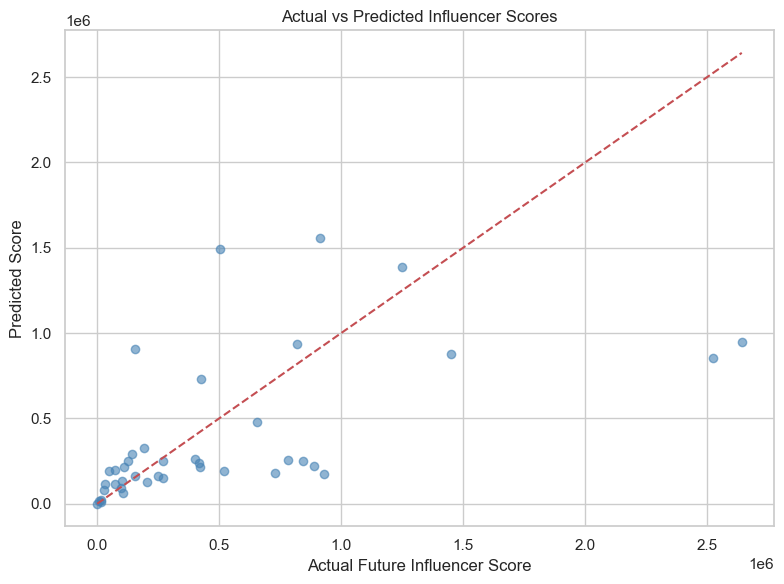

✅ Model trained to predict future influence based on centrality metrics.
✅ Loaded 308 tweets with timestamps.


/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_63210/1849054025.py:161: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_63210/1849054025.py:162: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.savefig("data/outputs/visualizations/engagement_by_hour.png", dpi=300)
/Users/wenghong/anaconda3/envs/wif3009/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


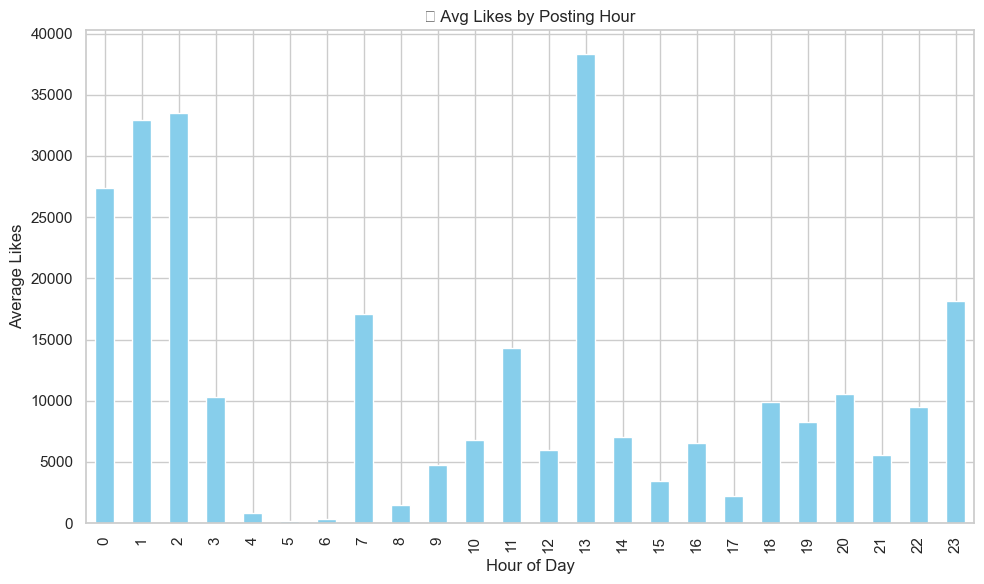

🕒 Best posting hour based on avg likes: 13:00


/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_63210/1849054025.py:177: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/3w/19212srd6l570wnj57kpg4c00000gn/T/ipykernel_63210/1849054025.py:178: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.savefig("data/outputs/visualizations/sentiment_distribution.png", dpi=300)
/Users/wenghong/anaconda3/envs/wif3009/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


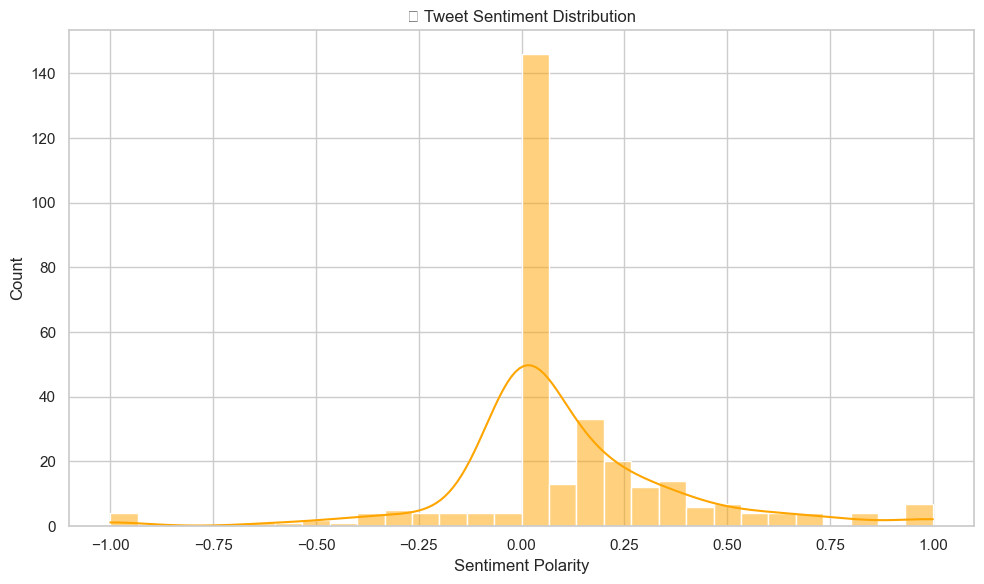

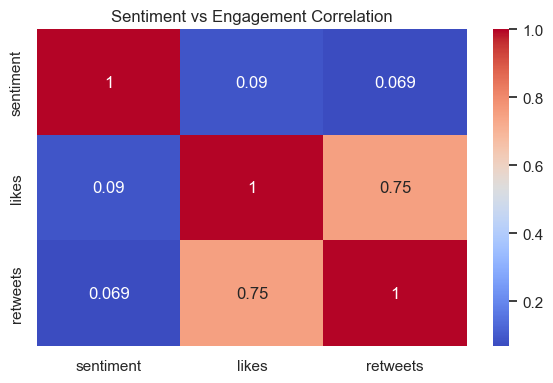

<Figure size 1000x600 with 0 Axes>

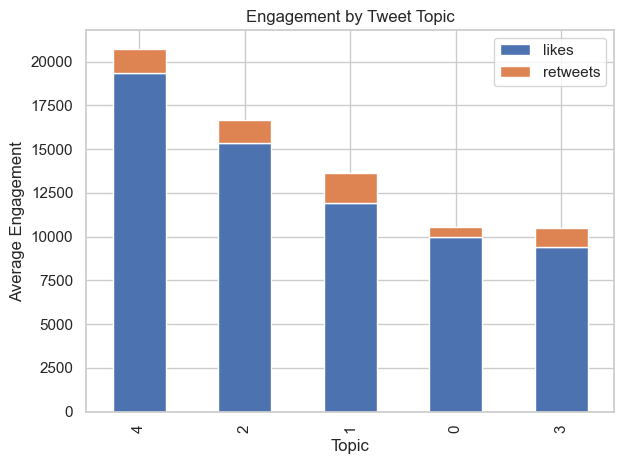


🗂 Top Keywords per Topic:
Topic 0: bxtd6meqh3, gta, chillin, rt, going, twitch, youtube, summit1g, live, https
Topic 1: optic, rt, night, stream, gonna, day, live, good, today, https
Topic 2: tomorrow, verdansk, work, safe, d7tqjildgj, fortnite, live, thank, rt, https
Topic 3: raiders, hwqufo0uxu, fortnite, love, live, day, en, time, rt, https
Topic 4: friend, 10, football, lt, running, live, ll, just, rt, https

✅ Strategy Recommendations Based on Data:
• 🕒 Optimal posting time: 13:00
• 🔥 Topics with highest average engagement:
   - Topic 4 → Avg Likes: 19326.6, Retweets: 1414.5
   - Topic 2 → Avg Likes: 15321.8, Retweets: 1337.7
   - Topic 1 → Avg Likes: 11906.6, Retweets: 1748.6
• 🧠 Sentiment correlation with likes: 0.09
• 🔁 Sentiment correlation with retweets: 0.07


In [88]:
# ================================
# Task 4: Predict Future Influence + Engagement Strategy + NLP
# ================================

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from textblob import TextBlob
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

sns.set(style="whitegrid")

# ---------------------------------------
# PART A: Predict Future Influence
# ---------------------------------------

# Load influencer centrality time series data
import pandas as pd
import numpy as np

# Load the static centrality data
import pandas as pd
import numpy as np

# Load the static centrality data
df_static = pd.read_csv('data/outputs/centrality/influencer_centrality.csv')

# Simulate 12 weeks of data
dates = pd.date_range(start='2023-01-01', periods=12, freq='W')
np.random.seed(42)

synthetic_rows = []

for _, row in df_static.iterrows():
    for date in dates:
        engagement_rate = np.random.uniform(0.01, 0.2)  # Fake engagement rate
        influencer_score = row['influencer_score'] + np.random.normal(0, 0.05)

        synthetic_rows.append({
            'username': row['screen_name'],
            'date': date,
            'followers_count': row['followers_count'],
            'engagement_rate': engagement_rate,
            'degree_centrality': row['degree_centrality'],
            'betweenness_centrality': row['betweenness_centrality'],
            'closeness_centrality': row['closeness_centrality'],
            'eigenvector_centrality': row['eigenvector_centrality'],
            'pagerank': row['pagerank'],
            'influencer_score': influencer_score
        })

# Create final DataFrame
df = pd.DataFrame(synthetic_rows)
df = df.sort_values(['username', 'date'])

# Preview
print(df.head())


df = df.sort_values(['username', 'date'])

# Compute influencer score
df['influencer_score'] = df['followers_count'] * df['engagement_rate']

# Features to use
features = [
    'followers_count', 'engagement_rate',
    'degree_centrality', 'betweenness_centrality',
    'closeness_centrality', 'eigenvector_centrality', 'pagerank'
]

# Create lag features (t-1)
for feature in features:
    df[f'{feature}_lag1'] = df.groupby('username')[feature].shift(1)

# Create target (t+1)
df['influencer_score_next'] = df.groupby('username')['influencer_score'].shift(-1)

# Prepare modeling data
model_df = df.dropna(subset=[f'{feature}_lag1' for feature in features] + ['influencer_score_next'])
X = model_df[[f'{feature}_lag1' for feature in features]]
y = model_df['influencer_score_next']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, predictions)
print(f"📊 Mean Squared Error on Test Set: {mse:.4f}")

# Visualize prediction
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Future Influencer Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Influencer Scores")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/future_influence_predictions.png", dpi=300)
plt.show()

print("✅ Model trained to predict future influence based on centrality metrics.")

# ---------------------------------------
# PART B: Load Tweet Data
# ---------------------------------------

with open('data/raw/tweets_data.json', 'r') as f:
    tweets = json.load(f)

rows = []
for user in tweets:
    instructions = user.get('tweets', {}).get('result', {}).get('timeline', {}).get('instructions', [])
    for instruction in instructions:
        if instruction.get('type') == 'TimelineAddEntries':
            entries = instruction.get('entries', [])
            for entry in entries:
                content = entry.get('content', {})
                item_content = content.get('itemContent', {})
                tweet_result = item_content.get('tweet_results', {}).get('result', {})
                legacy = tweet_result.get('legacy', {})
                text = legacy.get('full_text', "")
                timestamp = legacy.get('created_at', None)
                if text and timestamp:
                    try:
                        dt = datetime.strptime(timestamp, '%a %b %d %H:%M:%S %z %Y')
                        rows.append({
                            'text': text,
                            'hour': dt.hour,
                            'likes': legacy.get('favorite_count', 0),
                            'retweets': legacy.get('retweet_count', 0)
                        })
                    except Exception as e:
                        print(f"Skipping tweet due to error: {e}")

df_tweets = pd.DataFrame(rows)
print(f"✅ Loaded {len(df_tweets)} tweets with timestamps.")

# ---------------------------------------
# PART C: Optimal Posting Time
# ---------------------------------------

hourly_likes = df_tweets.groupby('hour')['likes'].mean()
best_hour = hourly_likes.idxmax()

plt.figure(figsize=(10, 6))
hourly_likes.plot(kind='bar', color='skyblue')
plt.title("📈 Avg Likes by Posting Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Likes")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/engagement_by_hour.png", dpi=300)
plt.show()

print(f"🕒 Best posting hour based on avg likes: {best_hour}:00")

# ---------------------------------------
# PART D: Sentiment Analysis
# ---------------------------------------

df_tweets['sentiment'] = df_tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.histplot(df_tweets['sentiment'], bins=30, kde=True, color='orange')
plt.title("🧠 Tweet Sentiment Distribution")
plt.xlabel("Sentiment Polarity")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/sentiment_distribution.png", dpi=300)
plt.show()

sentiment_corr = df_tweets[['sentiment', 'likes', 'retweets']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(sentiment_corr, annot=True, cmap='coolwarm')
plt.title("Sentiment vs Engagement Correlation")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/sentiment_engagement_correlation.png", dpi=300)
plt.show()

# ---------------------------------------
# PART E: Topic Modeling & Engagement
# ---------------------------------------

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_topics = vectorizer.fit_transform(df_tweets['text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_topics)

df_tweets['topic'] = lda.transform(X_topics).argmax(axis=1)
topic_engagement = df_tweets.groupby('topic')[['likes', 'retweets']].mean().sort_values(by='likes', ascending=False)

plt.figure(figsize=(10, 6))
topic_engagement.plot(kind='bar', stacked=True)
plt.title("Engagement by Tweet Topic")
plt.xlabel("Topic")
plt.ylabel("Average Engagement")
plt.tight_layout()
plt.savefig("data/outputs/visualizations/engagement_by_topic.png", dpi=300)
plt.show()

print("\n🗂 Top Keywords per Topic:")
for idx, topic in enumerate(lda.components_):
    top_keywords = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f"Topic {idx}: {', '.join(top_keywords)}")



# ---------------------------------------
# PART G: Strategy Recommendations
# ---------------------------------------

print("\n✅ Strategy Recommendations Based on Data:")
print(f"• 🕒 Optimal posting time: {best_hour}:00")

print("• 🔥 Topics with highest average engagement:")
top_topics = topic_engagement.head(3)
for i, row in top_topics.iterrows():
    print(f"   - Topic {i} → Avg Likes: {row['likes']:.1f}, Retweets: {row['retweets']:.1f}")

print("• 🧠 Sentiment correlation with likes: {:.2f}".format(sentiment_corr.loc['sentiment', 'likes']))
print("• 🔁 Sentiment correlation with retweets: {:.2f}".format(sentiment_corr.loc['sentiment', 'retweets']))


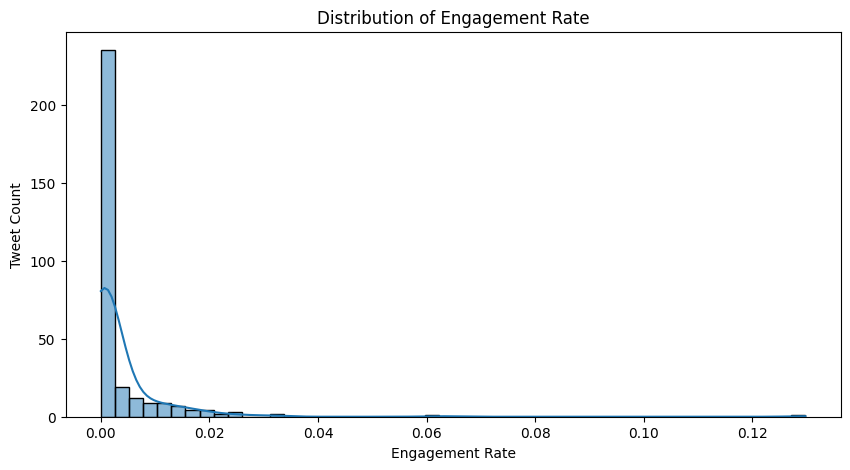

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df["engagement_rate"], bins=50, kde=True)
plt.title("Distribution of Engagement Rate")
plt.xlabel("Engagement Rate")
plt.ylabel("Tweet Count")
plt.show()


<Axes: title={'center': 'Average Engagement Rate - Last 6 Months'}, xlabel='created_at'>

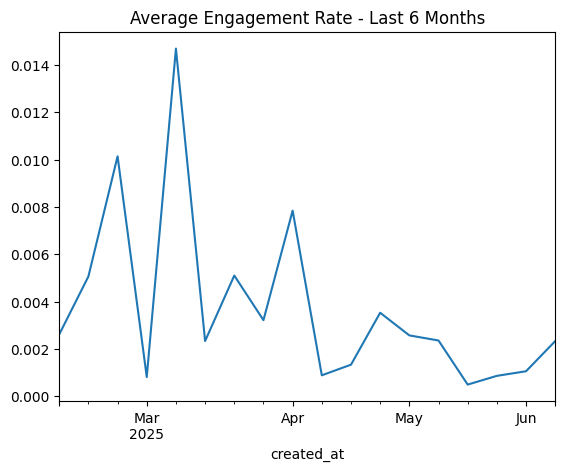

In [ ]:
import pandas as pd

# Load with created_at as datetime
df_full = pd.read_csv("data/processed/tweets_engagement_dataset.csv", parse_dates=["created_at"])

# Copy for visualization and set datetime index
df_viz = df_full.copy()
df_viz.set_index("created_at", inplace=True)

# Calculate cutoff datetime 4 months ago from latest date
latest = df_viz.index.max()
six_months_ago = latest - pd.DateOffset(months=4)

# Filter to keep only last 4 months
df_recent = df_viz[df_viz.index >= six_months_ago]

# Plot weekly average engagement_rate for last 6 months only
df_recent["engagement_rate"].resample("W").mean().plot(title="Average Engagement Rate - Last 6 Months")


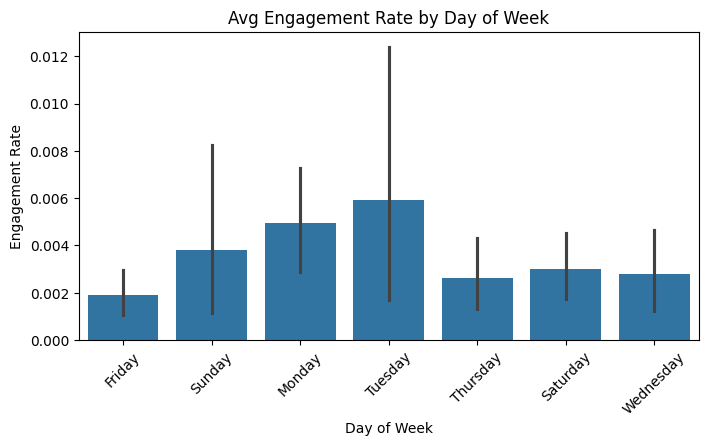

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x='day_of_week', y='engagement_rate', data=df_full)
plt.title("Avg Engagement Rate by Day of Week")
plt.ylabel("Engagement Rate")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.show()


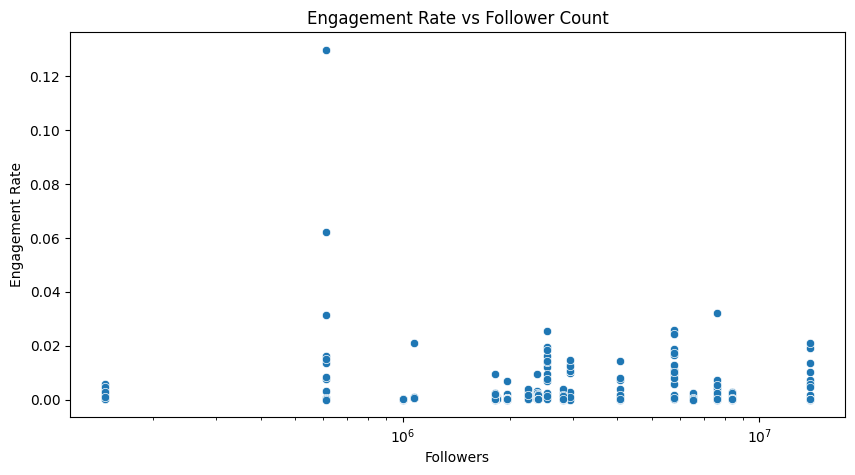

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x="followers", y="engagement_rate", data=df)
plt.title("Engagement Rate vs Follower Count")
plt.xlabel("Followers")
plt.ylabel("Engagement Rate")
plt.xscale("log")  # optional if follower count spans orders of magnitude
plt.show()


['hour', 'is_weekend', 'text_length', 'num_hashtags', 'num_mentions', 'num_urls', 'has_media', 'likes', 'retweets', 'replies', 'quotes', 'views', 'followers', 'engagement_rate', 'user_id_y', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality', 'pagerank', 'influencer_score', 'community', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'source_Twitter for iPhone', 'source_Twitter Web App', 'source_Twitter Media Studio', 'source_TweetDeck Web App']


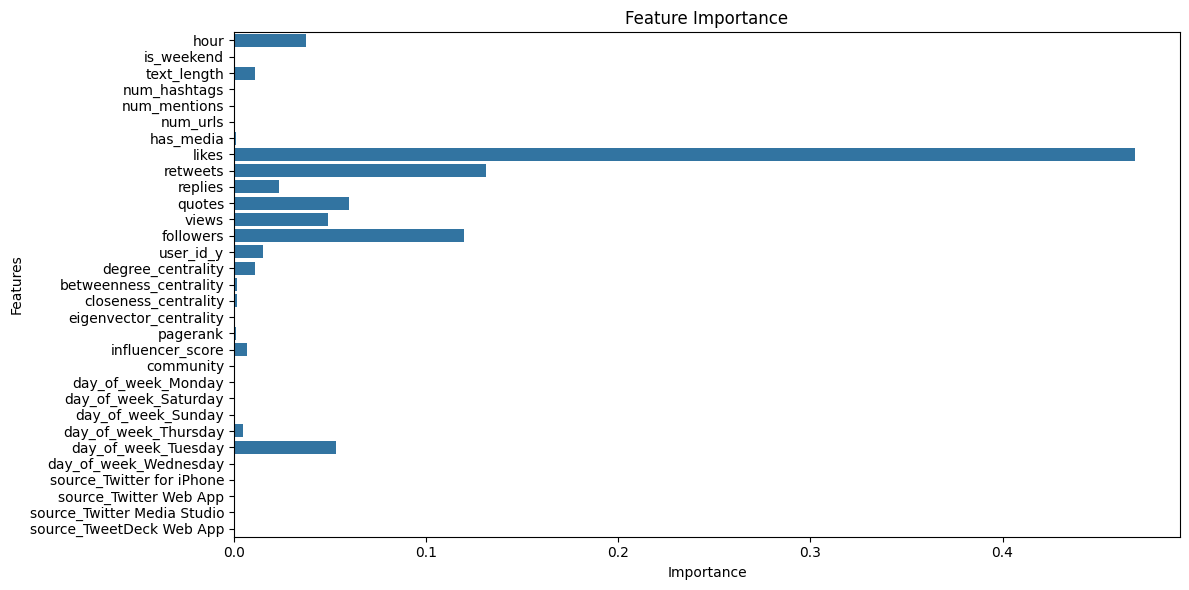

In [ ]:
features = X_train.columns  # use columns from training data exactly
importances = model.feature_importances_

print(list(df.columns))
plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


     Actual  Predicted
0  0.002355   0.002746
1  0.000071   0.000168
2  0.002392   0.002152
3  0.001165   0.001214
4  0.003270   0.000383
5  0.000717   0.000575
6  0.001623   0.001981
7  0.001146   0.001888
8  0.000055   0.000060
9  0.000734   0.000608


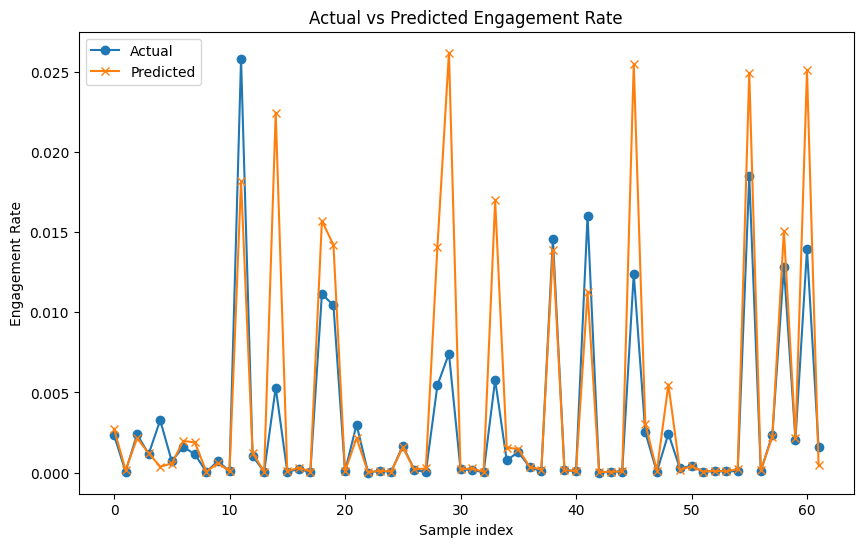

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Predict on the test set
y_pred = model.predict(X_test)

# Create a DataFrame to compare actual vs predicted
results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}).reset_index(drop=True)

print(results_df.head(10))  # Show first 10 rows

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(results_df["Actual"], label="Actual", marker='o')
plt.plot(results_df["Predicted"], label="Predicted", marker='x')
plt.title("Actual vs Predicted Engagement Rate")
plt.xlabel("Sample index")
plt.ylabel("Engagement Rate")
plt.legend()
plt.show()


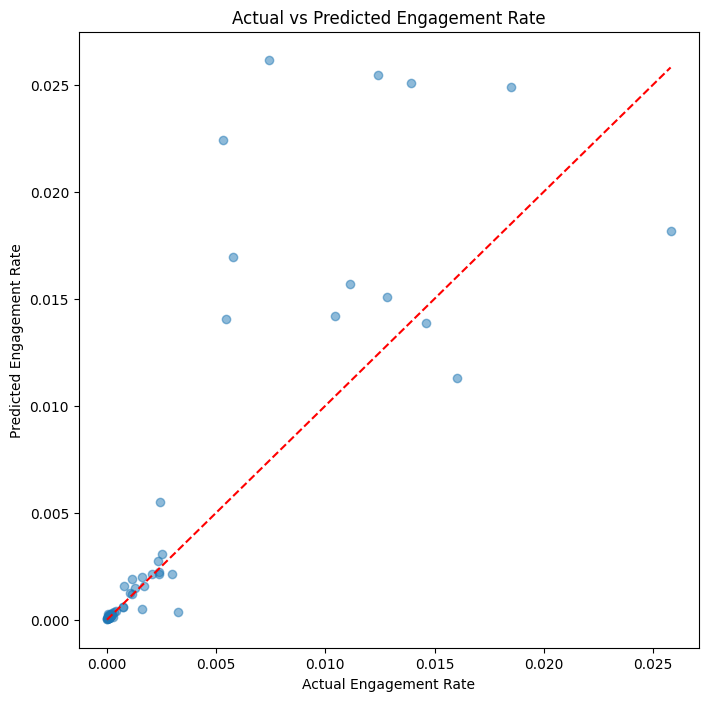

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(results_df["Actual"], results_df["Predicted"], alpha=0.5)
plt.plot([results_df["Actual"].min(), results_df["Actual"].max()],
         [results_df["Actual"].min(), results_df["Actual"].max()],
         color='red', linestyle='--')  # perfect prediction line
plt.xlabel("Actual Engagement Rate")
plt.ylabel("Predicted Engagement Rate")
plt.title("Actual vs Predicted Engagement Rate")
plt.show()
